# Pampers Only
Start by only considering one product and trying to determine the optimal strategy

In [6]:
using CSV, JuMP

avg_demand = CSV.read("AverageDemandForecast.csv")

lb_demand = CSV.read("LowerBoundDemandForecast.csv")

ub_demand = CSV.read("UpperBoundDemandForecast.csv")

pampers_avg = zeros(Float64, 52)
pampers_lb = zeros(Float64, 52)
pampers_ub = zeros(Float64, 52)
ub_avg_diff = zeros(Float64, 52)

for i in 2:length(names(avg_demand))
    pampers_avg[(i-2)*2 + 1] = avg_demand[i][1]/2
    pampers_avg[(i-2)*2 + 2] = avg_demand[i][1]/2
    
    pampers_lb[(i-2)*2 + 1] = lb_demand[i][1]/2
    pampers_lb[(i-2)*2 + 2] = lb_demand[i][1]/2
    
    pampers_ub[(i-2)*2 + 1] = ub_demand[i][1]/2
    pampers_ub[(i-2)*2 + 2] = ub_demand[i][1]/2
    
    ub_avg_diff[(i-2)*2 + 1] = pampers_ub[(i-2)*2 + 1] - pampers_avg[(i-2)*2 + 1]
    ub_avg_diff[(i-2)*2 + 2] = pampers_ub[(i-2)*2 + 2] - pampers_avg[(i-2)*2 + 2]
    
end


safety_stock_heur = maximum(ub_avg_diff)
typical_avg_demand = sum(pampers_avg)/52

production_capacity_pallets  = 40
biweekly_replenishment = 80
units_per_pallet = 576
unsatisfied_cost_per_unit = 100

inv_per_unit_per_week = .5*7

possible_reorder_lead_time = [1, 2, 3, 4, 5]
prod_cost = [25, 7.5, 2.5, 1, .5]

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[6]:15
└ @ Core ./In[6]:15
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[6]:16
└ @ Core ./In[6]:16
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[6]:18
└ @ Core ./In[6]:18
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[6]:19
└ @ Core ./In[6]:19
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[6]:21
└ @ Core ./In[6]:21
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[6]:22
└ @ Core ./In[6]:22


5-element Array{Float64,1}:
 25.0
  7.5
  2.5
  1.0
  0.5

In [2]:
using CSV, JuMP, Cbc

#found an equation for reorder quantity, but it doesn't seem solid when actually applied
#sqrt(2* quant required * order cost/ carrying cost per item)
#so for right now, we're going to let that be a variable in the formulation

m = Model(with_optimizer(Cbc.Optimizer, logLevel = 0))

@variable(m, 0 <= reorder_lead_time <= 5, Int)
@variable(m, reorder_amt_pallet >= 0, Int)

#note that the model will also assume that I start at a reorder point
#my reorder point heuristic is avg demand*lead time + safety stock
@expression(m, reorder_point, typical_avg_demand*reorder_lead_time + safety_stock_heur)

#I'm also assuming for the sake of simplicity that we experience avg_demand
#and simulate what that looks like given a certain lead time, amount ordered, and reorder point
simulated_demand = pampers_avg

#running tab of how much we have on hand for every week
@expression(m, amt_on_hand[1:52], 0)
#binary variable to express whether or not an order of the reorder amount is placed in any given week
@expression(m, order_placed[1:52], 0)

@expression(m, storage_costs, 0)
@expression(m, shipping_costs, 0)
@expression(m, unmet_orders_costs, 0)

amt_on_hand[1] = reorder_point
order_placed[1] = 1

for week in 2:52
    #simulate recieving orders
    if week-reorder_lead_time > 0
        if order_placed[week-reorder_lead_time] == week
            amt_on_hand[week] += reorder_amt_pallet*units_per_pallet
        end
    end
    
    println("checkpt 2")
    
    #simulate failing to fulfil orders
    if amt_on_hand[week] <= simulated_demand[week]
        unmet_orders_cost += (simulated_demand[week]-amt_on_hand[week])*unsatisfied_cost_per_unit
        amt_on_hand[week] = 0
    end
    
    println("checkpt 3")
    
    #simulate fulfilling orders and having excess on hand
    if amt_on_hand[week] > simulated_demand[week]
        amt_on_hand[week] += -simulated_demand[week]
        storage_costs += (amt_on_hand[week])*inv_per_unit_per_week
    end
    
    println("checkpt 4")
    
    #simulate placing an order
    if amt_on_hand[week] <= reorder_point
        order_placed[week] = 1
        shipping_costs += reorder_amt_pallet*prod_cost[reorder_lead_time]
    end
    
    println("checkpt 5")
end

@objective(m, Min, storage_costs+shipping_costs+unmet_orders_costs)
optimize!(m)

println("Objective Value: ", JuMP.objective_value(m))

MethodError: MethodError: no method matching isless(::Int64, ::GenericAffExpr{Float64,VariableRef})
Closest candidates are:
  isless(!Matched::Missing, ::Any) at missing.jl:87
  isless(::Real, !Matched::AbstractFloat) at operators.jl:157
  isless(::Integer, !Matched::ForwardDiff.Dual{Ty,V,N} where N where V) where Ty at /Users/eobermaier/.julia/packages/ForwardDiff/cXTw0/src/dual.jl:140
  ...

In [7]:
#trying to almost hard code the optimization that i was trying to do above
#this is pretty gross though, and will only get worse when i try to incorporate other products
#treating revenue like negative costs

simulated_demand = pampers_avg

best_cost = -1
best_breakdown = -1
best_reorder_lead_time = -1
best_reorder_amt_pallet = -1
inventory_over_time = -1
reorder_actions = -1

amt_on_hand = zeros(Float64, 52)
order_placed = zeros(Float64, 52)

for reorder_lead_time in 1:5
    for reorder_amt_pallet in 1:production_capacity_pallets
        
        storage_costs = 0
        shipping_costs = 0
        unmet_orders_costs = 0
        
        reorder_point = typical_avg_demand*reorder_lead_time + safety_stock_heur
        
        amt_on_hand[1] = reorder_point
        order_placed[1] = 1
        
        #simulate week over week
        for week in 2:52
            #the amount that we end with in a previous week should be how much we start with on a given week
            amt_on_hand[week] = amt_on_hand[week-1]
            
            #simulate recieving orders - biweekly replenishment on odd weeks and anything extra
            if week%2 == 1
                amt_on_hand[week] += biweekly_replenishment*units_per_pallet
            end
            
            if week-reorder_lead_time > 0
                if order_placed[week-reorder_lead_time] == 1
                    amt_on_hand[week] += reorder_amt_pallet*units_per_pallet
                end
            end
            
            #simulate failing to fulfil orders
            if amt_on_hand[week] <= simulated_demand[week]
                unmet_orders_costs += (simulated_demand[week]-amt_on_hand[week])*unsatisfied_cost_per_unit
                amt_on_hand[week] = 0
            end
            
            #simulate fulfilling orders and having excess on hand
            if amt_on_hand[week] > simulated_demand[week]
                amt_on_hand[week] += -simulated_demand[week]
                storage_costs += (amt_on_hand[week])*inv_per_unit_per_week
            end
            
            #simulate placing an order
            if amt_on_hand[week] <= reorder_point
                reorder_needed = true
                
                for i in 1:reorder_lead_time
                    if week-i > 0
                        if order_placed[week-i] == 1
                            reorder_needed = false
                        end
                    end
                end
                
                if reorder_needed
                    order_placed[week] = 1
                    shipping_costs += reorder_amt_pallet*prod_cost[reorder_lead_time]
                end
            end
            
        end
        
        #figure out the best option
        if best_cost == -1
            best_cost = storage_costs + shipping_costs + unmet_orders_costs
            best_breakdown = (storage_costs, shipping_costs, unmet_orders_costs)
            best_reorder_lead_time = reorder_lead_time
            best_reorder_amt_pallet = reorder_amt_pallet
            inventory_over_time = amt_on_hand
            reorder_actions = order_placed
        end
        
        if best_cost > storage_costs + shipping_costs + unmet_orders_costs
            best_cost = storage_costs + shipping_costs + unmet_orders_costs
            best_breakdown = (storage_costs, shipping_costs, unmet_orders_costs)
            best_reorder_lead_time = reorder_lead_time
            best_reorder_amt_pallet = reorder_amt_pallet
            inventory_over_time = amt_on_hand
            reorder_actions = order_placed
        end
        
    end
end

println(best_cost)
println(best_breakdown)
println("")
println(best_reorder_lead_time)
println(best_reorder_amt_pallet)
println("")
println(inventory_over_time)
println("")
println(reorder_actions)

1.2651877173076903e7
(1.2647877173076903e7, 4000.0, 0)

1
20

[130761.03846153845, 111309.03846153845, 143987.03846153844, 130585.03846153844, 161200.03846153844, 168775.03846153844, 193346.53846153844, 171838.03846153844, 195601.03846153844, 173284.03846153844, 200007.53846153844, 180651.03846153844, 211695.03846153844, 196659.03846153844, 225096.53846153844, 207454.03846153844, 231873.03846153844, 210212.03846153844, 235640.53846153844, 214989.03846153844, 236359.03846153844, 211649.03846153844, 238398.03846153844, 219067.03846153844, 237951.53846153844, 210756.03846153844, 229890.53846153844, 202945.03846153844, 227655.03846153844, 206285.03846153844, 220669.53846153844, 188974.03846153844, 211638.03846153844, 188222.03846153844, 197731.53846153844, 161161.03846153844, 170981.53846153844, 134722.03846153844, 140141.03846153844, 99480.03846153844, 118839.53846153844, 92119.03846153844, 132542.53846153844, 103846.03846153844, 142479.53846153844, 111993.03846153844, 151659.03846153844,

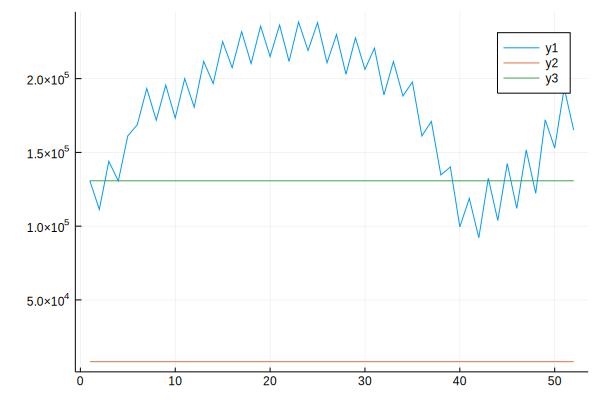

In [8]:
#graphing results

using Plots 
x = 1:52
y = inventory_over_time
z = zeros(Float64, 52)
r = zeros(Float64, 52)
for i in 1:52
    z[i] = safety_stock_heur
    r[i] = reorder_point
end

plot(x, y)
plot!(x, z)
plot!(x, r)

what if instead I say we really have the upper bound of demand... does that change decision? does it change the ratio of costs?

In [9]:
#trying to almost hard code the optimization that i was trying to do above
#this is pretty gross though, and will only get worse when i try to incorporate other products
#treating revenue like negative costs

simulated_demand = pampers_ub

best_cost = -1
best_breakdown = -1
best_reorder_lead_time = -1
best_reorder_amt_pallet = -1
inventory_over_time = -1
reorder_actions = -1

amt_on_hand = zeros(Float64, 52)
order_placed = zeros(Float64, 52)

for reorder_lead_time in 1:5
    for reorder_amt_pallet in 1:production_capacity_pallets
        
        storage_costs = 0
        shipping_costs = 0
        unmet_orders_costs = 0
        
        reorder_point = typical_avg_demand*reorder_lead_time + safety_stock_heur
        
        amt_on_hand[1] = reorder_point
        order_placed[1] = 1
        
        #simulate week over week
        for week in 2:52
            #the amount that we end with in a previous week should be how much we start with on a given week
            amt_on_hand[week] = amt_on_hand[week-1]
            
            #simulate recieving orders - biweekly replenishment on odd weeks and anything extra
            if week%2 == 1
                amt_on_hand[week] += biweekly_replenishment*units_per_pallet
            end
            
            if week-reorder_lead_time > 0
                if order_placed[week-reorder_lead_time] == 1
                    amt_on_hand[week] += reorder_amt_pallet*units_per_pallet
                end
            end
            
            #simulate failing to fulfil orders
            if amt_on_hand[week] <= simulated_demand[week]
                unmet_orders_costs += (simulated_demand[week]-amt_on_hand[week])*unsatisfied_cost_per_unit
                amt_on_hand[week] = 0
            end
            
            #simulate fulfilling orders and having excess on hand
            if amt_on_hand[week] > simulated_demand[week]
                amt_on_hand[week] += -simulated_demand[week]
                storage_costs += (amt_on_hand[week])*inv_per_unit_per_week
            end
            
            #simulate placing an order
            if amt_on_hand[week] <= reorder_point
                reorder_needed = true
                
                for i in 1:reorder_lead_time
                    if week-i > 0
                        if order_placed[week-i] == 1
                            reorder_needed = false
                        end
                    end
                end
                
                if reorder_needed
                    order_placed[week] = 1
                    shipping_costs += reorder_amt_pallet*prod_cost[reorder_lead_time]
                end
            end
            
        end
        
        #figure out the best option
        if best_cost == -1
            best_cost = storage_costs + shipping_costs + unmet_orders_costs
            best_breakdown = (storage_costs, shipping_costs, unmet_orders_costs)
            best_reorder_lead_time = reorder_lead_time
            best_reorder_amt_pallet = reorder_amt_pallet
            inventory_over_time = amt_on_hand
            reorder_actions = order_placed
        end
        
        if best_cost > storage_costs + shipping_costs + unmet_orders_costs
            best_cost = storage_costs + shipping_costs + unmet_orders_costs
            best_breakdown = (storage_costs, shipping_costs, unmet_orders_costs)
            best_reorder_lead_time = reorder_lead_time
            best_reorder_amt_pallet = reorder_amt_pallet
            inventory_over_time = amt_on_hand
            reorder_actions = order_placed
        end
        
    end
end

println(best_cost)
println(best_breakdown)
println("")
println(best_reorder_lead_time)
println(best_reorder_amt_pallet)
println("")
println(inventory_over_time)
println("")
println(reorder_actions)

1.65488279230769e7
(1.65457029230769e7, 3125.0, 0)

1
25

[130761.03846153845, 107418.53846153845, 137416.03846153844, 121333.53846153844, 148856.03846153844, 153338.53846153844, 173608.03846153844, 147797.53846153844, 190137.03846153844, 163356.53846153844, 186209.03846153844, 162981.53846153844, 214058.03846153844, 196014.53846153844, 243963.53846153844, 222792.53846153844, 265919.03846153844, 239925.53846153844, 284264.03846153844, 259482.53846153844, 275910.53846153844, 246258.53846153844, 292181.53846153844, 268984.53846153844, 305470.03846153844, 272835.53846153844, 309621.03846153844, 277286.53846153844, 320762.53846153844, 295118.53846153844, 326204.03846153844, 288169.53846153844, 329190.03846153844, 301090.53846153844, 326326.03846153844, 282441.53846153844, 308050.03846153844, 264538.53846153844, 284865.53846153844, 236072.53846153844, 273127.53846153844, 241062.53846153844, 275746.53846153844, 241310.53846153844, 273847.03846153844, 237263.53846153844, 271038.53846153844, 2

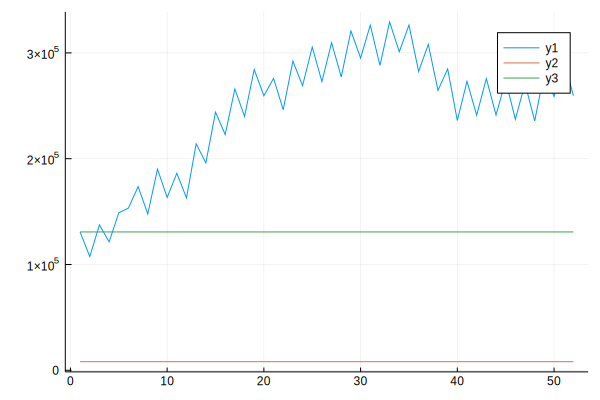

In [10]:
#graphing results

using Plots 
x = 1:52
y = inventory_over_time
z = zeros(Float64, 52)
r = zeros(Float64, 52)
for i in 1:52
    z[i] = safety_stock_heur
    r[i] = reorder_point
end

plot(x, y)
plot!(x, z)
plot!(x, r)

# Whole Problem
Expand to consider each product, and note storage capacity (though it's not figured in as a constraint)

In [20]:
using CSV, JuMP

avg_demand = CSV.read("AverageDemandForecast.csv")

lb_demand = CSV.read("LowerBoundDemandForecast.csv")

ub_demand = CSV.read("UpperBoundDemandForecast.csv")

prod_capacity = CSV.read("MaxProductionCapacity.csv")

prod_avgs = Dict()
prod_ubs = Dict()
prod_lbs = Dict()
safety_stocks = Dict()
typical_avg_demand = Dict()
production_capacity_pallet = Dict()
biweekly_replenishment = Dict()
units_per_pallet = Dict()
unsatisfied_cost_per_unit = Dict()

prod_names = convert(Array, avg_demand[1])
deleteat!(prod_names, 35)

println(prod_names)

for i in 1:34
    avgs = zeros(Float64, 52)
    lbs = zeros(Float64, 52)
    ubs = zeros(Float64, 52)
    ub_avg_diff = zeros(Float64, 52)
    
    for j in 2:27
        avgs[(j-2)*2 + 1] = avg_demand[j][i]/2
        avgs[(j-2)*2 + 2] = avg_demand[j][i]/2
        
        lbs[(j-2)*2 + 1] = lb_demand[j][i]/2
        lbs[(j-2)*2 + 2] = lb_demand[j][i]/2
        
        ubs[(j-2)*2 + 1] = ub_demand[j][i]/2
        ubs[(j-2)*2 + 2] = ub_demand[j][i]/2
        
        ub_avg_diff[(j-2)*2 + 1] = ubs[(j-2)*2 + 1] - avgs[(j-2)*2 + 1]
        ub_avg_diff[(j-2)*2 + 2] = ubs[(j-2)*2 + 2] - avgs[(j-2)*2 + 2]
    end
    
    prod_avgs[prod_names[i]] = avgs
    prod_ubs[prod_names[i]] = ubs
    prod_lbs[prod_names[i]] = lbs
    
    safety_stocks[prod_names[i]] = maximum(ub_avg_diff)
    typical_avg_demand[prod_names[i]] = sum(avgs)/52
    
    production_capacity_pallet[prod_names[i]] = prod_capacity[3][i]
    biweekly_replenishment[prod_names[i]] = prod_capacity[2][i]
    units_per_pallet[prod_names[i]] = prod_capacity[3][i]
    
    if i in 1:2
        unsatisfied_cost_per_unit[prod_names[i]] = 100
    elseif i in 3:6
        unsatisfied_cost_per_unit[prod_names[i]] = 40
    elseif i in 7:9
        unsatisfied_cost_per_unit[prod_names[i]] = 20
    elseif i in 10:11
        unsatisfied_cost_per_unit[prod_names[i]] = 15
    elseif i in 12:15
        unsatisfied_cost_per_unit[prod_names[i]] = 40
    elseif i in 16:19
        unsatisfied_cost_per_unit[prod_names[i]] = 16
    elseif i in 20:24
        unsatisfied_cost_per_unit[prod_names[i]] = 30
    elseif i in 25:28
        unsatisfied_cost_per_unit[prod_names[i]] = 90
    elseif i in 29:30
        unsatisfied_cost_per_unit[prod_names[i]] = 20
    elseif i in 31:34
        unsatisfied_cost_per_unit[prod_names[i]] = 80
    end
    
    
end


inv_per_unit_per_week = .5*7

possible_reorder_lead_time = [1, 2, 3, 4, 5]
prod_cost = [25, 7.5, 2.5, 1, .5]

println(prod_avgs["Pampers Diapers"])

thread = 1 warning: only found 3 / 4 columns on data row: 35. Filling remaining columns with `missing`
Union{Missing, String}["Pampers Diapers", "Luvs Diapers", "Tide Pods", "Gain Detergent", "Downy Fabric Softener", "Bounce Dryer Sheets", "Bounty Paper Towels", "Charmin Toilet Paper", "Puffs Tissues", "Always Pads", "Tampax Tampons", "Gillette Mach3 Turbo", "Braun Razors", "Gillette Venus Swirl", "Gillette Shaving Cream", "Pantene", "Head & Shoulders", "Herbal Essences", "Aussie", "Mr. Clean Magic Erasers", "Swiffers", "Cascade Pods", "Dawn Dish Soap", "Febreze Air Freshener", "Oral B Toothbrushes", "Crest Mouthwash", "Crest Toothpaste", "Crest Whitestrips", "DayQuil", "MetaMucil", "Olay Moisturizer", "Secret Deodorant", "Old Spice Deodorant", "SK-II Facial Treatments"]


┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[20]:20
└ @ Core In[20]:20
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[20]:33
└ @ Core ./In[20]:33
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[20]:34
└ @ Core ./In[20]:34
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[20]:36
└ @ Core ./In[20]:36
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[20]:37
└ @ Core ./In[20]:37
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[20]:39
└ @ Core ./In[20]:39


[19452.0, 19452.0, 13402.0, 13402.0, 15465.0, 15465.0, 21508.5, 21508.5, 22317.0, 22317.0, 19356.5, 19356.5, 15036.0, 15036.0, 17642.5, 17642.5, 21661.0, 21661.0, 20651.5, 20651.5, 24710.0, 24710.0, 19331.0, 19331.0, 27195.5, 27195.5, 26945.5, 26945.5, 21370.0, 21370.0, 31695.5, 31695.5, 23416.0, 23416.0, 36570.5, 36570.5, 36259.5, 36259.5, 40661.0, 40661.0, 26720.5, 26720.5, 28696.5, 28696.5, 30486.5, 30486.5, 29454.0, 29454.0, 19180.0, 19180.0, 28487.0, 28487.0]


In [27]:
best_costs = Dict()
best_breakdowns = Dict()
best_reorder_lead_times = Dict()
best_reorder_amt_pallets = Dict()
inventories_over_time = Dict()
reorder_actions_lists = Dict()

for p in prod_names
    simulated_demand = prod_avgs[p]

    best_cost = -1
    best_breakdown = -1
    best_reorder_lead_time = -1
    best_reorder_amt_pallet = -1
    inventory_over_time = -1
    reorder_actions = -1

    amt_on_hand = zeros(Float64, 52)
    order_placed = zeros(Float64, 52)

    for reorder_lead_time in 1:5
        for reorder_amt_pallet in 1:production_capacity_pallet[p]
        
            storage_costs = 0
            shipping_costs = 0
            unmet_orders_costs = 0
        
            reorder_point = typical_avg_demand[p]*reorder_lead_time + safety_stocks[p]
        
            amt_on_hand[1] = reorder_point
            order_placed[1] = 1
        
            #simulate week over week
            for week in 2:52
                #the amount that we end with in a previous week should be how much we start with on a given week
                amt_on_hand[week] = amt_on_hand[week-1]
            
                #simulate recieving orders - biweekly replenishment on odd weeks and anything extra
                if week%2 == 1
                    amt_on_hand[week] += biweekly_replenishment[p]*units_per_pallet[p]
                end
            
                if week-reorder_lead_time > 0
                    if order_placed[week-reorder_lead_time] == 1
                        amt_on_hand[week] += reorder_amt_pallet*units_per_pallet[p]
                    end
                end
            
                #simulate failing to fulfil orders
                if amt_on_hand[week] <= simulated_demand[week]
                    unmet_orders_costs += (simulated_demand[week]-amt_on_hand[week])*unsatisfied_cost_per_unit[p]
                    amt_on_hand[week] = 0
                end
            
                #simulate fulfilling orders and having excess on hand
                if amt_on_hand[week] > simulated_demand[week]
                    amt_on_hand[week] += -simulated_demand[week]
                    storage_costs += (amt_on_hand[week])*inv_per_unit_per_week
                end
            
                #simulate placing an order
                if amt_on_hand[week] <= reorder_point
                    reorder_needed = true
                
                    for i in 1:reorder_lead_time
                        if week-i > 0
                            if order_placed[week-i] == 1
                                reorder_needed = false
                            end
                        end
                    end
                
                    if reorder_needed
                        order_placed[week] = 1
                        shipping_costs += reorder_amt_pallet*prod_cost[reorder_lead_time]
                    end
                end
            
            end
        
            #figure out the best option
            if best_cost == -1
                best_cost = storage_costs + shipping_costs + unmet_orders_costs
                best_breakdown = (storage_costs, shipping_costs, unmet_orders_costs)
                best_reorder_lead_time = reorder_lead_time
                best_reorder_amt_pallet = reorder_amt_pallet
                inventory_over_time = amt_on_hand
                reorder_actions = order_placed
            end
        
            if best_cost > storage_costs + shipping_costs + unmet_orders_costs
                best_cost = storage_costs + shipping_costs + unmet_orders_costs
                best_breakdown = (storage_costs, shipping_costs, unmet_orders_costs)
                best_reorder_lead_time = reorder_lead_time
                best_reorder_amt_pallet = reorder_amt_pallet
                inventory_over_time = amt_on_hand
                reorder_actions = order_placed
            end
        
        end
    end
    best_costs[p] = best_cost
    best_breakdowns[p] = best_breakdown
    best_reorder_lead_times[p] = best_reorder_lead_time
    best_reorder_amt_pallets[p] = best_reorder_amt_pallet
    inventories_over_time[p] = inventory_over_time
    reorder_actions_lists[p] = reorder_actions
end

println(best_costs["Pampers Diapers"])
println(best_breakdowns["Pampers Diapers"])
println("")
println(best_reorder_lead_times["Pampers Diapers"])
println(best_reorder_amt_pallets["Pampers Diapers"])
println("")
println(inventories_over_time["Pampers Diapers"])
println("")
println(reorder_actions_lists["Pampers Diapers"])

1.0245090248076923e8
(1.7780063269230763e6, 0, 1.0067289615384616e8)

5
40

[130761.03846153845, 111309.03846153845, 101107.03846153845, 87705.03846153845, 75440.03846153845, 61575.038461538454, 43266.538461538454, 23358.038461538454, 4241.038461538454, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0]
